In [1]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error , mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM , Dense , Dropout , GRU , Concatenate , Input , Conv1D , InputLayer
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping

<Strong> Grabbing the data from stored files (originally pulled from Binance) </Strong>

In [2]:
df_xrp = pd.read_csv("XRP_1h_data.csv")

In [3]:
df_xrp

,date,open,high,low,close,volume
0,2018-05-04 08:00:00,0.50000,1.50000,0.5000,0.92300,5090857.33
1,2018-05-04 09:00:00,0.92300,0.92850,0.9010,0.90199,3326696.10
2,2018-05-04 10:00:00,0.90199,0.91027,0.8951,0.90128,1176810.48
3,2018-05-04 11:00:00,0.90128,0.92130,0.8800,0.91596,1714233.92
4,2018-05-04 12:00:00,0.91596,0.92450,0.9000,0.90098,1323800.17
...,...,...,...,...,...,...
33012,2022-02-11 10:00:00,0.81860,0.82180,0.8105,0.81860,13705481.00
33013,2022-02-11 11:00:00,0.81850,0.82080,0.8138,0.81510,7748847.00
33014,2022-02-11 12:00:00,0.81510,0.82120,0.8125,0.81660,16123801.00
33015,2022-02-11 13:00:00,0.81650,0.83390,0.8147,0.82320,24000643.00


In [4]:
df_headers = df_xrp.columns

<Strong> Grabbing the closing price (univariate) </Strong>

In [5]:
# Removing everything but the closing price
xrp_data = df_xrp.values[:, 4 ,].astype(float)

len(xrp_data)

33017

<Strong> Scaling the data  </Strong>

In [6]:
percTrain = 70
percVal = 20 

In [7]:
onePercent = len(xrp_data) // 100
numberTraining = onePercent * percTrain

scaler = MinMaxScaler()
reshaped_data = xrp_data.reshape(-1,1)

#Just scaling on training data otherwise it would be leakage
scaler.fit(reshaped_data[:numberTraining])
scaled_xrp = scaler.transform(reshaped_data)

<Strong> Creating Matrix in Sliding window form <Strong>

In [8]:
def sliding_window(elements, window_size):
    
    data = [] 
    targets = []
    
    if len(elements) <= window_size:
        return elements
    
    for i in range(len(elements) - window_size ):
        
        data.append(elements[i:i+window_size])
        targets.append(elements[i+window_size])
        
    return np.array(data) , np.array(targets)

In [9]:
window_length = 24
features = 1

sliding_winda_xrp = sliding_window(scaled_xrp , window_length)

<Strong> Splitting the data after we create Sliding Window matrix (more data) </Strong>

In [10]:
# Splitting the data after creating the sliding window data

def splitting_train_test(data):
        
    onePercent = len(data[1]) // 100
    
    numberTraining = onePercent * percTrain
    numberValidation = onePercent * percVal
    
    trainingData = data[0][:numberTraining] , data[1][:numberTraining]
    validationData = data[0][numberTraining : numberTraining + numberValidation] , data[1][numberTraining : numberTraining + numberValidation]
    testData = data[0][numberTraining + numberValidation:] , data[1][numberTraining + numberValidation:] 
    
    #Returning tuples of (sliding-window , target_values)
    return trainingData , validationData , testData

In [11]:
#Reshaping the data so we can use min-max a
xrp_train , xrp_val , xrp_test = splitting_train_test(sliding_winda_xrp)

print(xrp_train[0].shape)

(23030, 24, 1)


<Strong> Creating the model </Strong>

2022-03-08 16:44:48.709962: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 16:44:48.719689: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 16:44:48.720300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 16:44:48.721664: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 24, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 24, 30)       3840        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 24, 30)       0           ['lstm[0][0]']                   
                                                                                                  
 gru (GRU)                      (None, 30)           2970        ['input_1[0][0]']                
                                                                                              

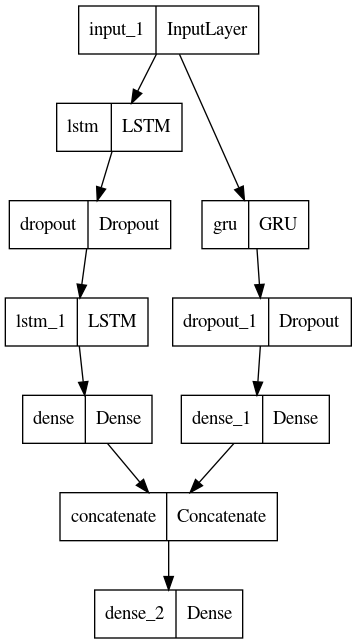

In [12]:
inputs = Input(shape = (window_length , features) )

#From deep learning in python -- better to use recurrent dropout so error propergates correctly
x = LSTM(30 , return_sequences = True )(inputs)
x = Dropout(0.01)(x) 
x = LSTM(50)(x)
x = Dense(128)(x)

y = GRU(30,input_shape=(window_length , features))(inputs)
y = Dropout(0.01)(y)
y = Dense(128)(y)

final = Concatenate()([x,y])
final = Dense(1)(final)

model = tf.keras.Model(inputs=inputs, outputs= final)

model.summary()
plot_model(model)

<Strong> Compiling the model </Strong>

In [13]:
model.compile(optimizer='adam' , loss = 'mse')

<Strong> Creating a callback to avail of early stopping </Strong>

In [14]:
earlyStopping = EarlyStopping(monitor = 'val_loss' , patience = 30 , mode = 'min' , verbose = 1)

<Strong> Training the model and storing the epoch training stopped on </Strong>

In [15]:
#Validation set needs to be in a tuple with x , y

history = model.fit(xrp_train[0] , xrp_train[1] , validation_data = xrp_val  , batch_size = 512  , epochs =300 , verbose = 1 , callbacks=[earlyStopping])
num_epochs = earlyStopping.stopped_epoch


Epoch 1/300


2022-03-08 16:44:54.144354: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


45/45 [==============================] - 6s 30ms/step - loss: 0.0101 - val_loss: 0.0013
Epoch 2/300
45/45 [==============================] - 0s 8ms/step - loss: 1.2068e-04 - val_loss: 0.0020
Epoch 3/300
45/45 [==============================] - 0s 8ms/step - loss: 7.4294e-05 - val_loss: 0.0021
Epoch 4/300
45/45 [==============================] - 0s 8ms/step - loss: 7.3106e-05 - val_loss: 0.0020
Epoch 5/300
45/45 [==============================] - 0s 8ms/step - loss: 7.1706e-05 - val_loss: 0.0019
Epoch 6/300
45/45 [==============================] - 0s 8ms/step - loss: 6.8732e-05 - val_loss: 0.0018
Epoch 7/300
45/45 [==============================] - 0s 8ms/step - loss: 6.9095e-05 - val_loss: 0.0017
Epoch 8/300
45/45 [==============================] - 0s 8ms/step - loss: 6.6909e-05 - val_loss: 0.0017
Epoch 9/300
45/45 [==============================] - 0s 8ms/step - loss: 6.6642e-05 - val_loss: 0.0014
Epoch 10/300
45/45 [==============================] - 0s 8ms/step - loss: 6.4621e-05 - v

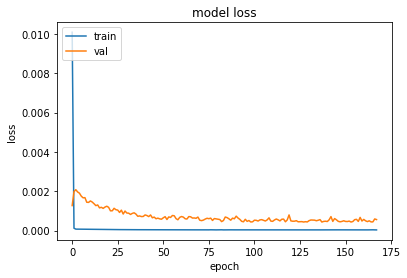

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<Strong> Testing on the validation data once again , hyper-parameter adjustment. <Strong>

In [17]:
validation_predict = model.predict(xrp_val[0])
validation_predict = scaler.inverse_transform(validation_predict)

#Transforming the targets back to original values
validation_actual = scaler.inverse_transform(xrp_val[1])
math.sqrt(mean_squared_error(validation_actual , validation_predict))

0.019230344701817427

<Strong> Combining the train and validation set when perfected hyper-parameters and training on fresh model. </Strong>

In [18]:
train_and_val = np.concatenate([xrp_train[0] , xrp_val[0]] )
train_and_val_targets = np.concatenate([xrp_train[1] , xrp_val[1] ])

freshModel = tf.keras.Model(inputs=inputs, outputs= final)
freshModel.compile(optimizer='adam' , loss = 'mse')

final = freshModel.fit(train_and_val , train_and_val_targets , batch_size = 512  , epochs = num_epochs )

Epoch 1/167
58/58 [==============================] - 4s 8ms/step - loss: 3.6346e-04
Epoch 2/167
58/58 [==============================] - 0s 7ms/step - loss: 1.4625e-04
Epoch 3/167
58/58 [==============================] - 0s 7ms/step - loss: 1.4259e-04
Epoch 4/167
58/58 [==============================] - 0s 7ms/step - loss: 1.4072e-04
Epoch 5/167
58/58 [==============================] - 0s 7ms/step - loss: 1.4929e-04
Epoch 6/167
58/58 [==============================] - 0s 7ms/step - loss: 1.4660e-04
Epoch 7/167
58/58 [==============================] - 0s 7ms/step - loss: 1.4503e-04
Epoch 8/167
58/58 [==============================] - 0s 7ms/step - loss: 1.5910e-04
Epoch 9/167
58/58 [==============================] - 0s 7ms/step - loss: 1.4616e-04
Epoch 10/167
58/58 [==============================] - 0s 7ms/step - loss: 1.5067e-04
Epoch 11/167
58/58 [==============================] - 0s 7ms/step - loss: 1.4821e-04
Epoch 12/167
58/58 [==============================] - 0s 7ms/step - loss: 

<Strong> Finally testing on test set and grabbing evaluation metrics </Strong>

In [19]:
test_predict = freshModel.predict(xrp_test[0])
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(xrp_test[1])

In [20]:
print(math.sqrt(mean_absolute_error(test_actual , test_predict)))
print(math.sqrt(mean_absolute_percentage_error(test_actual , test_predict)))
print(math.sqrt(mean_squared_error(test_actual , test_predict , squared = False)))
print(math.sqrt(mean_squared_error(test_actual , test_predict)))

0.08679539830292517
0.08995770178033913
0.10136534126293507
0.010274932409351288


<Strong> For Predicting more than 1 day in the future - Test Set. </Strong>

In [21]:
def steps_in_future(hours_in_future , data):
    
    #All the hours_in_future time predictions
    predictions = []
    
    # Have to cut off the (hours_in_future - 1) off the test set to avoid out of bounds error
    test_data = data[0][:-(hours_in_future - 1)]
    
    for x in range (len(test_data)):
        #Going through all the windows
        last_window = test_data[x].reshape(1,-1)
    
            # Make as many predictions as hours_in_future
        for i in range(hours_in_future):
            
            # Take the predicted value from the last window in training set
            last_prediction = model.predict(last_window)[0]

            #shifting the window size one step down
            last_window[0] = np.roll(last_window[0], -1)

            #replacing the old value with new prediction
            last_window[0 , (len(last_window[0]) - 1)] = last_prediction

        #append prediction
        predictions.append(last_prediction)
    
    return predictions

In [22]:
three_day_predictions = steps_in_future(3, xrp_test)
seven_day_predictions = steps_in_future( 7, xrp_test)

In [23]:
scaled_three_day_predictions = scaler.inverse_transform(three_day_predictions)
scaled_seven_day_predictions = scaler.inverse_transform(seven_day_predictions)

In [24]:
# Targets to compare  
targets_in_future_three = xrp_test[1][(3 - 1):]
targets_in_future_three = scaler.inverse_transform(targets_in_future_three)

targets_in_future_seven = xrp_test[1][(7 - 1):]
targets_in_future_seven = scaler.inverse_transform(targets_in_future_seven)

In [27]:
#print("mae" , math.sqrt(mean_absolute_error(targets_in_future_three , scaled_three_day_predictions)))
print(math.sqrt(mean_absolute_error(targets_in_future_seven , scaled_seven_day_predictions)))

#print("mse" ,math.sqrt(mean_squared_error(targets_in_future_three , scaled_three_day_predictions )))
print(math.sqrt(mean_squared_error(targets_in_future_seven , scaled_seven_day_predictions )))

#print("rmse" ,math.sqrt(mean_squared_error(targets_in_future_three , scaled_three_day_predictions , squared = False)))
print(math.sqrt(mean_squared_error(targets_in_future_seven , scaled_seven_day_predictions , squared = False)))

#print("mape" ,math.sqrt(mean_absolute_percentage_error(targets_in_future_three , scaled_three_day_predictions)))
print(math.sqrt(mean_absolute_percentage_error(targets_in_future_seven , scaled_seven_day_predictions)))

0.21597612916980433
0.05240472226076894
0.22892077725879087
0.22159300499051948
